# setting up initial functions

In [3]:
import aiohttp
import asyncio
import json
import socket
import time
from concurrent.futures import ThreadPoolExecutor
import nest_asyncio
nest_asyncio.apply()

In [4]:
session = aiohttp.ClientSession()

def scan_ip(ip):
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.settimeout(1)
            s.connect((ip, 80))
            return ip
    except:
        return None

def get_online_ips():
    online_ips = []
    with ThreadPoolExecutor(max_workers=256) as executor:
        futures = []
        for i in range(2, 256):
            ip = f"192.168.8.{i}"
            futures.append(executor.submit(scan_ip, ip))
        for future in futures:
            result = future.result()
            if result:
                online_ips.append(result)
    return online_ips

async def call_get(url):
    try:
        async with session.get(url, timeout=5) as response:  # 设置了5秒的超时
            return url, await response.text(), response.status
    except Exception as e:
        return url, str(e), None

async def get_hosts_status(ips):
    tasks = []
    for i in ips:
        url = f"http://" + i + "/?status"
        tasks.append(call_get(url))
    
    results = await asyncio.gather(*tasks)

    online_robots = []
    for url, content, status in results:
        if status and "html" not in content and "HTML" not in content and content != "":
            online_robots.append(json.loads(content))

    return online_robots

def get_online_robots():
    online_robots = get_online_ips()
    return asyncio.run(get_hosts_status(online_robots))

def refesh_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?status"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def set_robot(robot, M1_position:int, M1_power:int, M2_position:int, M2_power:int, M3_direction:bool, M3_power:int):
    if M1_position < -2147483648 or M1_position > 2147483647 or M2_position < -2147483648 or M2_position > 2147483647:
        raise ValueError("Motor position should be in [-2147483648, 2147483647]")
    elif M1_power < 0 or M1_power > 255 or M2_power < 0 or M2_power > 255 or M3_power < 0 or M3_power > 255:
        raise ValueError("Motor power should be in [0, 255]")
    
    action = f"{int32_to_hex(M1_position)}{hex(M1_power)[2:].upper().zfill(2)}{int32_to_hex(M2_position)}{hex(M2_power)[2:].upper().zfill(2)}{int(M3_direction)}{hex(M3_power)[2:].upper().zfill(2)}"
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?set={action}"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def calibrate_robot(robot, M1:bool, M2:bool):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?calibrate={int(M1)}{int(M2)}"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def reach_robot(robot, M1:bool, M2:bool):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?reach={int(M1)}{int(M2)}"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def pause_robot(robot, pause:bool):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?pause{int(pause)}"))
    if status and "html" not in content:
        return json.loads(content)
    else:
        return None
    
def int32_to_hex(value: int):
    if value < 0:
        value = 0xFFFFFFFF + value + 1
    return hex(value)[2:].zfill(8).upper()

def get_power_robot(robot):
    url, content, status = asyncio.run(call_get(f"http://{robot['ip']}/?power"))
    if status and "html" not in content:
        raw_json = json.loads(content)
        raw_power_data = raw_json['power']
        int_power_data = [int(raw_power_data[i:i+4], 16) for i in range(0, len(raw_power_data), 4)]
        result_data = []
        for i in range(0, len(int_power_data), 6):
            bus_bus = float(int_power_data[i] >> 3) * 0.008
            top_bus = float(int_power_data[i+1] >> 3) * 0.008
            bot_bus = float(int_power_data[i+2] >> 3) * 0.008
            bus_shunt = float(int_power_data[i+3] >> 3) * 0.00004
            top_shunt = float(int_power_data[i+4] >> 3) * 0.00004
            bot_shunt = float(int_power_data[i+5] >> 3) * 0.00004
            bus_current = bus_shunt / 0.02
            top_current = top_shunt / 0.04
            bot_current = bot_shunt / 0.04
            result_data.append({
                "BUS_V": bus_bus,
                "RIGHT_V": top_bus,
                "LEFT_V": bot_bus,
                "BUS_C": bus_current,
                "RIGHT_C": top_current,
                "LEFT_C": bot_current,
            })
        return result_data
    else:
        return None

In [5]:
# Your list of MAC addresses with their corresponding IDs
robots_mac = {
    0: "D8:3B:DA:C3:87:2E",
    1: "D8:3B:DA:C3:87:1E",
    2: "D8:3B:DA:C3:86:FE",
    3: "D8:3B:DA:C3:87:6A",
    4: "D8:3B:DA:C3:87:00",
    5: "D8:3B:DA:C3:87:9E",
    6: "D8:3B:DA:C3:87:20",
    7: "D8:3B:DA:C3:87:96",
    8: "D8:3B:DA:C3:87:26",
    9: "D8:3B:DA:C3:87:3E",
    10: "D8:3B:DA:C3:87:28",
    11: "D8:3B:DA:C3:87:6E",
    12: "D8:3B:DA:C3:87:5C",
    13: "D8:3B:DA:C3:87:10",
    14: "D8:3B:DA:C3:86:C6",
    15: "D8:3B:DA:C3:87:8E",
    16: "D8:3B:DA:C3:87:3A",
    17: "D8:3B:DA:C3:87:4E",
    18: "D8:3B:DA:C3:87:84",
    19: "D8:3B:DA:C3:87:A2",
    20: "D8:3B:DA:C3:87:70",
    21: "D8:3B:DA:C3:86:D4",
    22: "D8:3B:DA:C3:87:68",
    23: "D8:3B:DA:C3:87:3C",
    24: "D8:3B:DA:C3:86:D6",
    25: "D8:3B:DA:C3:87:98",
    26: "D8:3B:DA:C3:87:4C",
    27: "D8:3B:DA:C3:87:1C",
    28: "D8:3B:DA:C3:87:7C",
    29: "D8:3B:DA:C3:87:72",
    30: "D8:3B:DA:C3:87:1A"
}


# Function to detect online robots and map them by ID
def detect_online_robots():
    online_robots = get_online_robots()
    online_mac_addresses = {robot['mac'] for robot in online_robots}

    # Find online robot IDs
    online_robot_ids = [
        robot_id for robot_id, mac in robots_mac.items() if mac in online_mac_addresses
    ]

    # Map each online robot ID to its corresponding robot data
    robotwithID = {
        robot_id: robot for robot_id, mac in robots_mac.items() 
        if mac in online_mac_addresses for robot in online_robots if robot['mac'] == mac
    }

    return online_robot_ids, robotwithID


# two robots attachment

In [4]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)

# robot = robots[0]
# print(refesh_robot(robot))

Online Robots (IDs): [4, 6, 7, 18, 24, 25]


In [31]:
# To control a specific robot by its ID
robot_id1 = 9 # Example robot ID
robot_id2 = 20 # Example robot ID
robot1 = None
robot2 = None

robot1 = robotwithID[robot_id1]
robot2 = robotwithID[robot_id2]


In [ ]:
# print(set_robot(robotwithID[18], -1900, 255, -2400, 255, True, 0))

In [799]:
print(set_robot(robot1, -300, 255, -00, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 0, 'm1_target': -300, 'm2_current': -5, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.27, 'pause': False}


In [334]:
print(set_robot(robot, -5500, 255, 00, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': -5493, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.24, 'pause': False}


In [115]:
print(set_robot(robot2, -6000, 255, -6000, 255, True, 0))
# print(set_robot(robot1, -6000, 255, -6000, 255, True, 0))
time.sleep(1.5)
# print(set_robot(robot1, -6000, 20, -6000, 20, True, 0))
# print(set_robot(robot2, -6000, 20, -6000, 20, True, 0))
print(set_robot(robot2, -6000, 20, -6000, 20, True, 180))
# print(set_robot(robot1, -6000, 20, -6000, 20, True, 180))
# print(set_robot(robot1, 0, 20, 0, 20, True, 180))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -9, 'm1_target': -6000, 'm2_current': -4, 'm2_target': -6000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.15, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5972, 'm1_target': -6000, 'm2_current': -5994, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 4.14, 'pause': False}


In [135]:
print(set_robot(robot1,  -0, 255, -0, 255, True, 0))
print(set_robot(robot2,  -0, 255, -0, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.127', 'mac': 'D8:3B:DA:C3:87:3E', 'm1_current': -6008, 'm1_target': 0, 'm2_current': -6469, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.26, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.177', 'mac': 'D8:3B:DA:C3:87:70', 'm1_current': -5969, 'm1_target': 0, 'm2_current': -5970, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.24, 'pause': False}


In [105]:
print(set_robot(robot1,  -6000, 255, -6500, 255, True, 0))
print(set_robot(robot2,  -6000, 255, -6000, 255, True, 0))
# print(set_robot(robot2,  -0, 20, -0, 20, True, 180))

{'status': 'set ok', 'ip': '192.168.8.127', 'mac': 'D8:3B:DA:C3:87:3E', 'm1_current': -6008, 'm1_target': -6000, 'm2_current': -6470, 'm2_target': -6500, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.28, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.177', 'mac': 'D8:3B:DA:C3:87:70', 'm1_current': 0, 'm1_target': -6000, 'm2_current': 0, 'm2_target': -6000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.27, 'pause': False}


In [133]:
print(set_robot(robot1,  -6000, 20, -6500, 20, True, 180))
# print(set_robot(robot2,  -6000, 20, -6000, 20, True, 180))

{'status': 'set ok', 'ip': '192.168.8.127', 'mac': 'D8:3B:DA:C3:87:3E', 'm1_current': -6008, 'm1_target': -6000, 'm2_current': -6469, 'm2_target': -6500, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 1.27, 'pause': False}


In [134]:
print(set_robot(robot1,  -6000, 20, -6500, 20, False, 180))
# print(set_robot(robot2,  -6000, 20, -6000, 20, False, 180))
time.sleep(0.5)
print(set_robot(robot1, -6000, 20, -6500,20,  False, 0))
print(set_robot(robot2, -6000, 20, -6000,20,  False, 0))

{'status': 'set ok', 'ip': '192.168.8.127', 'mac': 'D8:3B:DA:C3:87:3E', 'm1_current': -6008, 'm1_target': -6000, 'm2_current': -6469, 'm2_target': -6500, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 1.24, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.127', 'mac': 'D8:3B:DA:C3:87:3E', 'm1_current': -6008, 'm1_target': -6000, 'm2_current': -6469, 'm2_target': -6500, 'm1_power': 20, 'm2_power': 20, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.24, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.177', 'mac': 'D8:3B:DA:C3:87:70', 'm1_current': -5969, 'm1_target': -6000, 'm2_current': -5970, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.25, 'pause': False}


In [116]:
print(set_robot(robot2,  -6000, 20, -6000, 20, False, 180))
# print(set_robot(robot1, -6000, 20, -6000, 20, False, 180))
# print(set_robot(robot1, -0, 20, -0, 20, False, 180))
time.sleep(0.5)
print(set_robot(robot2, -6000, 20, -6000,20,  False, 0))
# print(set_robot(robot1, -6000, 20, -6000, 20, False, 0))
# print(set_robot(robot1, -0, 20, -0, 20, False, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5972, 'm1_target': -6000, 'm2_current': -5994, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 4.07, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5972, 'm1_target': -6000, 'm2_current': -5994, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.07, 'pause': False}


In [118]:
print(set_robot(robot2, 0, 255, 0, 255, True, 0))
print(set_robot(robot1, 0, 255,  0, 255, False, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -7, 'm1_target': 0, 'm2_current': -3, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.15, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 0, 'm1_target': 0, 'm2_current': 1, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.14, 'pause': False}


In [710]:
print(set_robot(robot2, -6000, 255, -6000, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -1, 'm1_target': -6000, 'm2_current': 13, 'm2_target': -6000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.95, 'pause': False}


In [711]:
print(set_robot(robot2, -6000, 20, -6000, 20, True, 180))
print(set_robot(robot1, 0, 20,  0, 20, False, 180))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5976, 'm1_target': -6000, 'm2_current': -6029, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.95, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 14, 'm1_target': 0, 'm2_current': 2, 'm2_target': 0, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.98, 'pause': False}


In [712]:
print(set_robot(robot2,  -6000, 20, -6000, 20, False, 180))
print(set_robot(robot1, 00, 20, 0, 20, True, 180))
time.sleep(0.5)
print(set_robot(robot2, -6000, 20, -6000,20,  False, 0))
print(set_robot(robot1, 00, 20, 00, 20, False, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5976, 'm1_target': -6000, 'm2_current': -6029, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.87, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 14, 'm1_target': 0, 'm2_current': 2, 'm2_target': 0, 'm1_power': 20, 'm2_power': 20, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.91, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -5976, 'm1_target': -6000, 'm2_current': -6029, 'm2_target': -6000, 'm1_power': 20, 'm2_power': 20, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.87, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 14, 'm1_target': 0, 'm2_current': 2, 'm2_target': 0, 'm1_power': 20, 'm2_power': 20, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'ba

In [690]:
print(set_robot(robot1, -0, 255, -4500, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 20, 'm1_target': 0, 'm2_current': -8, 'm2_target': -4500, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.99, 'pause': False}


In [691]:
print(set_robot(robot1, -2000, 255, 0, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 20, 'm1_target': -2000, 'm2_current': -4478, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.99, 'pause': False}


In [692]:
print(set_robot(robot1, 0, 255, 0, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': -2008, 'm1_target': 0, 'm2_current': 2, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.99, 'pause': False}


In [379]:
print(set_robot(robot2, 0, 255, 00, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.03, 'pause': False}


In [522]:
print(set_robot(robot2, 0, 255, 00, 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -17, 'm1_target': 0, 'm2_current': 2, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.92, 'pause': False}


In [497]:
print(set_robot(robot1, 0, 255,-300 , 255, True, 0))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 26, 'm1_target': 0, 'm2_current': 13, 'm2_target': -300, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.11, 'pause': False}


In [801]:
print(calibrate_robot(robot1, True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.27, 'pause': False}


In [ ]:
# print(calibrate_robot(robotwithID[18], True, True))

# single robot locomotion

In [136]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)

robot_id = 7 # Example robot ID

robot = robotwithID[robot_id]

Online Robots (IDs): [3, 7, 9, 16, 24, 26]


In [769]:
## on ground -- single robot
for i in range(5):
    # Now you can use the set_robot function
    set_robot(robot, -00, 255, -5500, 255, True, 0)
    time.sleep(1)
    set_robot(robot, -00, 255, -00, 255, True, 0)
    time.sleep(1)
    set_robot(robot, -5500, 255, -00, 255, True, 0)
    time.sleep(1)
    set_robot(robot, -00, 255, -00, 255, True, 0)
    time.sleep(1)
set_robot(robot, -00, 255, -0, 255, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.143',
 'mac': 'D8:3B:DA:C3:87:4E',
 'm1_current': -26,
 'm1_target': 0,
 'm2_current': -28,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.16,
 'pause': False}

In [787]:
for i in range(4):
    set_robot(robot, -5500, 255, -5500, 255, True, 0)
    time.sleep(1)
    set_robot(robot, -00, 255, -00, 255, False, 0)
    time.sleep(1)

In [58]:
#### STOP!!!!!
set_robot(robot, 0, 255, 0, 255, True, 0)
print("stop")

stop


In [255]:
set_robot(robot, 0, 255, 0, 255, True, 255)
print("forward")

forward


In [243]:
set_robot(robot, 0, 255, -3000, 255, True, 255)
print("left")

left


In [244]:
set_robot(robot, -3000, 255, 0, 255, True, 255)
print("right")

right


In [138]:
set_robot(robot, -6700, 255, -6400, 255, True, 0)
time.sleep(1.5)
set_robot(robot, -6700, 20, -6400, 20, True, 0)
print("compress")

compress


In [ ]:
set_robot(robot, -6000, 20, -6000, 20, True, 180)
print("compress -- forward")

In [258]:
## COT !!! TEST COT!!!!!

import time
import json
from datetime import datetime

power_data = get_power_robot(robot)

filename = "SNAKE_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".json"

# Save the Python object to a JSON file
with open(filename, "w") as json_file:
    json.dump(power_data, json_file, indent=4)

print(f"Data has been saved to {filename}")


Data has been saved to SNAKE_20241111_162403.json


In [785]:
print(calibrate_robot(robot, True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.143', 'mac': 'D8:3B:DA:C3:87:4E', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.16, 'pause': False}


# multiple robot locomotion -- on ground

In [20]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)
print(len(online_robot_ids))

Online Robots (IDs): [2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 17, 22, 23, 24, 25, 26]
16


In [415]:
## Set the robot to be use firstly
robots_id = [5,23,11,22,17]
used_robots = []


for robot_id in robots_id:
    if robot_id in robotwithID:
        robot = robotwithID[robot_id]
        print("Using Robot with ID:", robot_id)
        used_robots.append(robot)
    else:
        print(f"Robot with ID {robot_id} is not online.")

if len(used_robots) == len(robots_id):
    print("Got all robots")
else:
    print("Some robot is not detected!! WRONG!!!")

Using Robot with ID: 5
Using Robot with ID: 23
Using Robot with ID: 11
Using Robot with ID: 22
Using Robot with ID: 17
Got all robots


In [87]:
robots_id = [15, 6, 7, 25]

In [102]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, False, 0)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 0)
print("stop")

stop


In [100]:
# forward
# set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 200)
# set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 200)
# set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 220)
print("forward")

forward


In [48]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 180)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 250)
print("25")

backward


In [81]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 180)
print("6")

6


In [82]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 180)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 200)
print("15")

15


In [64]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 180)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 200)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 200)
print("7")

7


In [83]:
# forward
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, False, 200)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, False, 200)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, False, 200)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, False, 200)
print("forward")

forward


In [ ]:
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 0)
print("forward")

In [ ]:
set_robot(robotwithID[robots_id[0]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[1]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[2]], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[robots_id[3]], 0, 255, -00, 255, True, 0)
print("forward")

In [377]:
# turn_right
set_robot(robotwithID[22], 0, 255, -00, 255, True, 230)
set_robot(robotwithID[6], 0, 255, -00, 255, True, 230)
set_robot(robotwithID[3], 0, 255, -00, 255, False, 230)
set_robot(robotwithID[1], 0, 255, -00, 255, False, 230)
print("right")

right


In [372]:
# turn_left
set_robot(robotwithID[22], 0, 255, -00, 255, False, 230)
set_robot(robotwithID[6], 0, 255, -00, 255, False, 230)
set_robot(robotwithID[3], 0, 255, -00, 255, True, 230)
set_robot(robotwithID[1], 0, 255, -00, 255, True, 230)
print("turn_left")

turn_left


In [374]:
# stop
set_robot(robotwithID[22], 0, 255, -00, 255, False, 0)
set_robot(robotwithID[6], 0, 255, -00, 255, False, 0)
set_robot(robotwithID[3], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[1], 0, 255, -00, 255, True, 0)
print("stop")

stop


In [375]:
# caging
set_robot(robotwithID[11], 0, 255, -3000, 255, False, 0)
set_robot(robotwithID[21], 0, 255, -3000, 255, False, 0)
set_robot(robotwithID[23], 0, 255, -3000, 255, True, 0)
set_robot(robotwithID[19], 0, 255, -3000, 255, True, 0)
# set_robot(robotwithID[2], 0, 255, -3000, 255, True, 0)
set_robot(robotwithID[25], 0, 255, -3000, 255, True, 0)
set_robot(robotwithID[18], 0, 255, -3000, 255, True, 0)
print("caging")

caging


In [378]:
set_robot(robotwithID[22], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[6], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[3], 0, 255, -00, 255, True, 250)
set_robot(robotwithID[1], 0, 255, -00, 255, True, 250)
print("forward")

forward


In [381]:
set_robot(robotwithID[22], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[6], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[3], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[1], 0, 255, -00, 255, True, 0)
print("stop")

stop


In [351]:
set_robot(robotwithID[18], 0, 255, -00, 255, False, 255)
set_robot(robotwithID[11], 0, 255, -00, 255, True, 205)
print("move after caging -- use other robots")

move after caging -- use other robots


In [352]:
set_robot(robotwithID[18], 0, 255, -00, 255, False, 0)
set_robot(robotwithID[11], 0, 255, -00, 255, True, 0)
print("stop after caging")

stop after caging


In [380]:
# caging -- origin
set_robot(robotwithID[11], 0, 255, -0, 255, False, 0)
set_robot(robotwithID[21], 0, 255, -0, 255, False, 0)
set_robot(robotwithID[23], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[19], 0, 255, -00, 255, True, 0)
# set_robot(robotwithID[2], 0, 255, -0, 255, True, 0)
set_robot(robotwithID[25], 0, 255, -00, 255, True, 0)
set_robot(robotwithID[18], 0, 255, -00, 255, True, 0)
print("cage-origin")

cage-origin


In [177]:
print(set_robot(robotwithID[1], 0, 255, -00, 255, True, 220))
print(set_robot(robotwithID[2], -3000, 255, 0, 255, True, 220))
print(set_robot(robotwithID[3], -3000, 255, -3000, 255, True, 220))
print(set_robot(robotwithID[18], 0, 255, -2000, 255, True, 220))
print(set_robot(robotwithID[19], 0, 255, -00, 255, True, 220))
print(set_robot(robotwithID[25], -4000, 255, -4000, 255, True, 220))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 6, 'm1_target': 0, 'm2_current': 10, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_error': 0, 'battery': 4.01, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -10, 'm1_target': -3000, 'm2_current': -8, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_error': 0, 'battery': 4.02, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.171', 'mac': 'D8:3B:DA:C3:87:6A', 'm1_current': 6, 'm1_target': -3000, 'm2_current': 2, 'm2_target': -3000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_error': 0, 'battery': 4.01, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.197', 'mac': 'D8:3B:DA:C3:87:84', 'm1_current': -22, 'm1_target': 0, 'm2_current': 22, 'm2_target': -2000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_error': 0, 'b

In [175]:
print(set_robot(robotwithID[1], 0, 255, -00, 255, False, 180))
print(set_robot(robotwithID[2], -3000, 255, 0, 255, False, 180))
print(set_robot(robotwithID[3], -3000, 255, -3000, 255, True, 220))
print(set_robot(robotwithID[18], 0, 255, -2000, 255, True, 220))
print(set_robot(robotwithID[19], 0, 255, -00, 255, True, 220))
print(set_robot(robotwithID[25], -4000, 255, -4000, 255, True, 220))
time.sleep(2)
print(set_robot(robotwithID[1], 0, 255, -00, 255, True, 220))
print(set_robot(robotwithID[2], -3000, 255, 0, 255, True, 220))
print(set_robot(robotwithID[3], -3000, 255, -3000, 255, True, 220))
print(set_robot(robotwithID[18], 0, 255, -2000, 255, True, 220))
print(set_robot(robotwithID[19], 0, 255, -00, 255, True, 220))
print(set_robot(robotwithID[25], -4000, 255, -4000, 255, True, 220))

{'status': 'set ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 6, 'm1_target': 0, 'm2_current': 10, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.89, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': -3011, 'm1_target': -3000, 'm2_current': -8, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 180, 'm1_error': 0, 'm2_error': 0, 'battery': 3.88, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.171', 'mac': 'D8:3B:DA:C3:87:6A', 'm1_current': -3015, 'm1_target': -3000, 'm2_current': -2994, 'm2_target': -3000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_error': 0, 'battery': 3.89, 'pause': False}
{'status': 'set ok', 'ip': '192.168.8.197', 'mac': 'D8:3B:DA:C3:87:84', 'm1_current': -22, 'm1_target': 0, 'm2_current': -2005, 'm2_target': -2000, 'm1_power': 255, 'm2_power': 255, 'm3_power': 220, 'm1_error': 0, 'm2_

In [131]:
print(calibrate_robot(robotwithID[1], True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.245', 'mac': 'D8:3B:DA:C3:87:1E', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.11, 'pause': False}


In [132]:
def move_chain_robot_left(used_robots):
    # Assuming `used_robots` is already populated
    if len(used_robots) >= 2:
        for _ in range(7):
            # Iterate over the indexes to control each robot
            for i in range(len(used_robots)):
                # Control the robots based on the index
                if i % 2 == 0:  # If the index is even
                    set_robot(used_robots[i], 0, 255, -5500, 255, True, 0)
                else:  # If the index is odd
                    # print(set_robot(used_robots[i], -5500, 255, 0, 255, True, 0))
                    set_robot(used_robots[i], -0, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
        
            # Switch the controls for odd and even indexes
            for j in range(len(used_robots)):
                if j % 2 == 1:  # If the index is odd
                    set_robot(used_robots[j], 0, 255, -5500, 255, True, 0)
                else:  # If the index is even
                    # print(set_robot(used_robots[j], -5500, 255, 0, 255, True, 0))
                    set_robot(used_robots[j], 0, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
    
    # Set all robots to the same state
    for robot in used_robots:
        set_robot(robot, 0, 255, 0, 255, True, 0)
    


In [451]:
def move_chain_robot_right(used_robots):
    # Assuming `used_robots` is already populated
    if len(used_robots) >= 2:
        for _ in range(7):
            # Iterate over the indexes to control each robot
            for i in range(len(used_robots)):
                # Control the robots based on the index
                if i % 2 == 0:  # If the index is even
                    set_robot(used_robots[i], 0, 255, 00, 255, True, 0)
                else:  # If the index is odd
                    set_robot(used_robots[i], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
        
            # Switch the controls for odd and even indexes
            for j in range(len(used_robots)):
                if j % 2 == 1:  # If the index is odd
                    set_robot(used_robots[j], 0, 255, 00, 255, True, 0)
                else:  # If the index is even
                    set_robot(used_robots[j], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
    
    # Set all robots to the same state
    for robot in used_robots:
        set_robot(robot, 0, 255, 0, 255, True, 0)
    


In [16]:
## Set the robot to be use firstly
robots_id = [21,8,25,15,6]
used_robots = []


for robot_id in robots_id:
    if robot_id in robotwithID:
        robot = robotwithID[robot_id]
        print("Using Robot with ID:", robot_id)
        used_robots.append(robot)
    else:
        print(f"Robot with ID {robot_id} is not online.")

if len(used_robots) == len(robots_id):
    print("Got all robots")
else:
    print("Some robot is not detected!! WRONG!!!")

Using Robot with ID: 21
Using Robot with ID: 8
Using Robot with ID: 25
Using Robot with ID: 15
Using Robot with ID: 6
Got all robots


In [17]:
def move_chain_robot_gait_ground(used_robots):
    # Assuming `used_robots` is already populated
    if len(used_robots) >= 2:
        for _ in range(20):
            # Iterate over the indexes to control each robot
            for i in range(len(used_robots)):
                # Control the robots based on the index
                if i in [0,1,4]:
                    set_robot(used_robots[i], 0, 255, -5500, 255, True, 0)
                elif i in [2,3]:  # If the index is odd
                    set_robot(used_robots[i], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
        
            # Switch the controls for odd and even indexes
            for j in range(len(used_robots)):
                if j in [2,3]:
                    set_robot(used_robots[j], 0, 255, -5500, 255, True, 0)
                elif j in [0,1,4]:  # If the index is even
                    set_robot(used_robots[j], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
    
    # Set all robots to the same state
    for robot in used_robots:
        set_robot(robot, 0, 255, 0, 255, True, 0)
    


In [18]:
def move_chain_robot_gait2(used_robots):
    # Assuming `used_robots` is already populated
    if len(used_robots) >= 2:
        for _ in range(20):
            # Iterate over the indexes to control each robot
            for i in range(len(used_robots)):
                # Control the robots based on the index
                if i in [3,4]:#[0,1,4]:
                    pass
                    # set_robot(used_robots[i], 0, 255, -5500, 255, True, 0)
                elif i in [0,1]: #[2,3]:  # If the index is odd
                    set_robot(used_robots[i], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(0.8)
        
            # Switch the controls for odd and even indexes
            for j in range(len(used_robots)):
                if j in [0,1]:#[2,3]:
                    set_robot(used_robots[j], 0, 255, -5500, 255, True, 0)
                elif j in [3,4]:#[0,1,4]:  # If the index is even
                    pass
                    # set_robot(used_robots[j], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(0.8)
    
    # Set all robots to the same state
    for robot in used_robots:
        set_robot(robot, 0, 255, 0, 255, True, 0)
    


In [19]:
def move_chain_robot_gait_roll(used_robots):
    # Assuming `used_robots` is already populated
    if len(used_robots) >= 2:
        for _ in range(1):
            # Iterate over the indexes to control each robot
            for i in range(len(used_robots)):
                set_robot(used_robots[i], 0, 255, -5000, 255, True, 0)
                # elif i in [3]:  # If the index is odd
                #     set_robot(used_robots[i], -5500, 255, 0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)
        
            # Switch the controls for odd and even indexes
            for j in range(len(used_robots)):
                set_robot(used_robots[j], -5000, 255, -0, 255, True, 0)
        
            # Wait for 1 second
            time.sleep(1)

            for j in range(len(used_robots)):
                set_robot(used_robots[j], -0, 255, -0, 255, True, 0)
        
            # Wait for 1 second
            # time.sleep(2)
    
    # Set all robots to the same state
    # for robot in used_robots:
    #     set_robot(robot, 0, 255, 0, 255, True, 0)
    


In [22]:
for robot in used_robots:
    set_robot(robot, 0, 255, 0, 255, True, 0)

In [ ]:
move_chain_robot_gait_ground(used_robots)

In [475]:
move_chain_robot_gait_roll(used_robots)

In [ ]:
move_chain_robot_left(used_robots)

In [453]:
move_chain_robot_right(used_robots)

In [192]:
len(used_robots)

5

In [31]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)

Online Robots (IDs): [0, 9, 13, 16, 18, 21, 27]


In [41]:
# Set all robots to the original state
for i in robotwithID:
        set_robot(robotwithID[i], 0, 255, 0, 255, False, 200)

In [40]:
# Set all robots to the original state
for i in robotwithID:
        set_robot(robotwithID[i], 0, 255, 0, 255, True, 200)

In [42]:
# Set all robots to the original state
for i in robotwithID:
        set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)

# plus sign

In [244]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)
print(len(online_robot_ids))

Online Robots (IDs): [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23, 25, 27]
20


In [71]:
set_robot(robotwithID[20], -6000, 255, -6000, 255, True, 0)
time.sleep(1.5) 
set_robot(robotwithID[20], -6000, 20, -6000, 20, True, 0)
print("compress")

compress


In [85]:
cur_speed = 190

In [132]:
set_robot(robotwithID[7], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[26], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[24], 0, 255, 0, 255, False, cur_speed)
set_robot(robotwithID[23], 0, 255, 0, 255, True, 0)
print("front")

front


In [106]:
set_robot(robotwithID[7], 0, 255, 0, 255, False, 0)
set_robot(robotwithID[26], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[24], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[23], 0, 255, 0, 255, False, cur_speed)
print("right")

right


In [104]:
set_robot(robotwithID[7], 0, 255, 0, 255, False, cur_speed)
set_robot(robotwithID[26], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[24], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[23], 0, 255, 0, 255, True, 0)
print("back")

back


In [118]:
set_robot(robotwithID[7], 0, 255, 0, 255, False, 0)
set_robot(robotwithID[26], 0, 255, 0, 255, False, cur_speed)
set_robot(robotwithID[24], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[23], 0, 255, 0, 255, True, cur_speed)
print("left")

left


In [120]:
set_robot(robotwithID[7], 0, 255, 0, 255, True, cur_speed) # front
set_robot(robotwithID[26], 0, 255, 0, 255, True, cur_speed) # right
set_robot(robotwithID[24], 0, 255, 0, 255, False, 0) # back
set_robot(robotwithID[23], 0, 255, 0, 255, True, 0) # left
print("front-right")

front-right


In [134]:
set_robot(robotwithID[7], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[26], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[24], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[23], 0, 255, 0, 255, True, 0)
print("back-right")

back-right


In [124]:
set_robot(robotwithID[7], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[26], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[24], 0, 255, 0, 255, False, 0)
set_robot(robotwithID[23], 0, 255, 0, 255, True, cur_speed)
print("front-left")

front-left


In [133]:
set_robot(robotwithID[7], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[26], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[24], 0, 255, 0, 255, True, cur_speed)
set_robot(robotwithID[23], 0, 255, 0, 255, True, cur_speed)
print("back-left")

back-left


In [137]:
set_robot(robotwithID[7], 0, 255, 0, 255, False, 0)
set_robot(robotwithID[26], 0, 255, 0, 255, False, 0)
set_robot(robotwithID[24], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[23], 0, 255, 0, 255, True, 0)
print("stop")

stop


# a chain locomote on the water

In [383]:
import time

# Variables

propeller_speed = 180  # Set desired propeller speed value

# time = 0
ids = [5, 23, 11, 22, 19, 17, 13]
X = -5000
speed = 200

def chain_undulate_step1():
    set_robot(robotwithID[ids[0]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[1]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[2]], 0, speed, 0, speed, True, propeller_speed)
    set_robot(robotwithID[ids[3]], X, speed, 0, speed, True, propeller_speed)
    set_robot(robotwithID[ids[4]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[5]], 0, speed, 0, speed, True, propeller_speed)
    set_robot(robotwithID[ids[6]], X, speed, 0, speed, True, propeller_speed)
    print("step 1")

def chain_undulate_step2():
    set_robot(robotwithID[ids[0]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[1]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[2]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[3]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[4]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[5]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[6]], 0, speed, 0, speed, True, propeller_speed)  # mod
    print("step 2")

def chain_undulate_step3():
    set_robot(robotwithID[ids[0]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[1]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[2]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[3]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[4]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[5]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[6]], 0, speed, X, speed, True, propeller_speed)
    print("step 3")

def chain_undulate_step4():
    set_robot(robotwithID[ids[0]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[1]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[2]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[3]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[4]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[6]], 0, speed, X, speed, True, propeller_speed)
    print("step 4")

def chain_undulate_step5():
    set_robot(robotwithID[ids[0]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[1]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[2]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[3]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[4]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[6]], 0, speed, 0, speed, True, propeller_speed)  # mod
    print("step 5")

def chain_undulate_step6():
    set_robot(robotwithID[ids[0]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[1]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[2]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[3]], X, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[4]], 0, speed, 0, speed, True, propeller_speed)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, X, speed, True, propeller_speed)
    set_robot(robotwithID[ids[6]], X, speed, 0, speed, True, propeller_speed)  # mod
    print("step 6")



In [384]:
for i in range(1):
    interval = 1  # seconds
    # Execute each function with 2-second interval
    chain_undulate_step1()
    # time.sleep(interval)
    
    # chain_undulate_step2()
    # time.sleep(interval)
    
    # chain_undulate_step3()
    # time.sleep(interval)
    
    # chain_undulate_step4()
    # time.sleep(interval)
    
    # chain_undulate_step5()
    # time.sleep(interval)
    
    # chain_undulate_step6()


step 1


# two chain of robots

In [127]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)
print(len(online_robot_ids))

Online Robots (IDs): [3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 17, 22, 23, 24, 25, 26]
16


In [451]:
set_robot(robotwithID[7], -7000, 20, -6000, 20, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.105',
 'mac': 'D8:3B:DA:C3:87:28',
 'm1_current': -5976,
 'm1_target': -6000,
 'm2_current': -5984,
 'm2_target': -6000,
 'm1_power': 20,
 'm2_power': 20,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.24,
 'pause': False}

In [192]:
## back to origin
# online_robot_ids
for i in online_robot_ids:   
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)
print("origin")

origin


In [195]:
left_id = [23, 8]
right_id = [13,26]
first_ids = [8,25,23,17]

In [200]:
# for i in first_ids:   
#     set_robot(robotwithID[i], 0, 255, 0, 255, False, 190)
# time.sleep(0.1)
for i in first_ids:   
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)
print("stop no compress")

stop no compress


In [198]:
## contactless
for i in first_ids:   
    set_robot(robotwithID[i], -0, 20, -0, 20, True, 200)
print("forward no compress")

forward no compress


In [189]:
for i in left_id:   
    set_robot(robotwithID[i], -0, 20, -0, 20, True, 200)
for i in right_id:   
    set_robot(robotwithID[i], -0, 20, -0, 20, True, 0)
print("right no compress")

right no compress


In [180]:
for i in right_id:   
    set_robot(robotwithID[i], -0, 20, -0, 20, True, 200)
for i in left_id:   
    set_robot(robotwithID[i], -0, 20, -0, 20, True, 0)
print("left no compress")

left no compress


In [191]:
ids = [23,8,13,26,17,25,24,4,22,9,11,10,5,3,6,14]
for i in ids:   
    set_robot(robotwithID[i], -6000, 255, -6000, 255, True, 0)
time.sleep(1.5)
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 0)
print("compress all robot!!!")

compress all robot!!!


In [250]:
# back the propeller
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 180)
time.sleep(0.3)
print("stop with back state")
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 0)


stop


In [ ]:
# forward the propeller
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 180)
time.sleep(0.3)
print("stop with back state")
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 0)

In [ ]:
## contactless
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 180)
    # set_robot(robotwithID[i], -0, 20, -0, 20, True, 170)
print("move all propeller --compress- backward")

In [581]:
## contactless
for i in ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 180)
    # set_robot(robotwithID[i], -0, 20, -0, 20, True, 170)
print("move all propeller --compress- forward")

move all propeller -- forward


In [249]:
lefts = [21, 12, 25, 6,17,13, 19, 22, 10, 23]
for i in online_robot_ids:  
    if i in lefts:
        set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 170)
    else:
        set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 0)
    # set_robot(robotwithID[i], -0, 20, -0, 20, True, 170)
print("move all propeller -- right")

move all propeller -- forward


In [ ]:
lefts = [21, 12, 25, 6,17,13, 19, 22, 10, 23]
for i in online_robot_ids:  
    if i in lefts:
        set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 0)
    else:
        set_robot(robotwithID[i], -6000, 20, -6000, 20, True, 170)
    # set_robot(robotwithID[i], -0, 20, -0, 20, True, 170)
print("move all propeller -- left")

In [252]:
for i in online_robot_ids:   
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 170)
time.sleep(0.4)
for i in online_robot_ids:
    set_robot(robotwithID[i], -6000, 20, -6000, 20, False, 0)
    # set_robot(robotwithID[i], -0, 20, -0, 20, False, 180)
print("compress- stop!!!!")

compress- stop!!!!


## non-prehensile manipulation

In [35]:
# time = 0
ids = [24, 7, 20, 13, 8,5,1]
ids_bottom = [12,26,23,19,16,6,25]
X = -4000
time_gap = 2

speed = 120


In [37]:
def nonprehensile_step1():
    # Group by index: 0, 1, 2, etc., from both ids and ids_bottom
    set_robot(robotwithID[ids[0]], -2000, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], 0, speed, -2000, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[1]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[1]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[2]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[3]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[4]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[4]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[5]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[6]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], 0, speed, X, speed, True, 0)
    
    # set_robot(robotwithID[ids[7]], 0, 255, X, 255, True, 0)
    # set_robot(robotwithID[ids_bottom[7]], X, 255, 0, 255, True, 0)
    
    print("step 1")


def nonprehensile_step2():
    # time.sleep(time_gap)
    
    # Group by index: 0, 1, 2, etc., from both ids and ids_bottom
    set_robot(robotwithID[ids[0]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[0]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[1]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[1]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[2]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[3]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[4]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[4]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[5]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[6]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], 0, speed, 0, speed, True, 0)
    
    # set_robot(robotwithID[ids[7]], X, 255, 0, 255, True, 0)
    # set_robot(robotwithID[ids_bottom[7]], 0, 255, X, 255, True, 0)
    
    print("step 2")
def nonprehensile_step3():
    # Group by index: 0, 1, 2, etc., from both ids and ids_bottom
    set_robot(robotwithID[ids[0]], 0, speed, -2000, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], -2000, speed, 0, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[1]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[1]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[2]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[3]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[4]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[4]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[5]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[6]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], X, speed, 0, speed, True, 0)
    
    print("step 3")



In [40]:

def nonprehensile_step11():
    # Group by index: 0, 1, 2, etc., from both ids and ids_bottom
    set_robot(robotwithID[ids[0]], -2000, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], 0, speed, -2000, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[1]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[1]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[2]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[3]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], 0, speed, X, speed, True, 0)
    
    set_robot(robotwithID[ids[4]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[4]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[5]], 0, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], 0, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[6]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], 0, speed, X, speed, True, 0)
    
    # set_robot(robotwithID[ids[7]], 0, 255, X, 255, True, 0)
    # set_robot(robotwithID[ids_bottom[7]], X, 255, 0, 255, True, 0)
    
    print("step 1")

def nonprehensile_step12():
    # Group by index: 0, 1, 2, etc., from both ids and ids_bottom
    set_robot(robotwithID[ids[0]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], 0, speed, 0, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[1]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[1]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[2]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[2]], 0, speed, X, speed, True, 0)  # mod

    set_robot(robotwithID[ids[3]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[3]], 0, speed, 0, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[4]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[4]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[5]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[5]], 0, speed, X, speed, True, 0)  # mod


    set_robot(robotwithID[ids[6]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[6]], 0, speed, 0, speed, True, 0)  # mod
    
    # set_robot(robotwithID[ids[7]], 0, speed, X, speed, True, 0)
    # set_robot(robotwithID[ids_bottom[7]], X, speed, 0, speed, True, 0)
    

    
    print("step 2")



def nonprehensile_step13():

    set_robot(robotwithID[ids[0]], 0, speed, -2000, speed, True, 0)
    set_robot(robotwithID[ids_bottom[0]], -2000, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids[1]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[1]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids[2]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[2]], 0, speed, X, speed, True, 0)  # mod


    
    set_robot(robotwithID[ids[3]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids[4]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[4]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids[5]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[5]], 0, speed, X, speed, True, 0)  # mod

    set_robot(robotwithID[ids[6]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], X, speed, 0, speed, True, 0)
    # set_robot(robotwithID[ids[7]], 0, speed, 0, speed, True, 0)  # mod
    # set_robot(robotwithID[ids_bottom[7]], 0, speed, 0, speed, True, 0)  # mod

    
    print("step 3")


def nonprehensile_step14():

    set_robot(robotwithID[ids[0]], 0, speed, -2000, speed, True, 0)
    set_robot(robotwithID[ids_bottom[0]], -2000, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids[1]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[1]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[2]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[2]], 0, speed, 0, speed, True, 0)  # mod
    
    set_robot(robotwithID[ids[3]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[3]], X, speed, 0, speed, True, 0)
    set_robot(robotwithID[ids[4]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[4]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[5]], 0, speed, 0, speed, True, 0)  # mod

    set_robot(robotwithID[ids[6]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[6]], X, speed, 0, speed, True, 0)
    # set_robot(robotwithID[ids[7]], X, speed, 0, speed, True, 0)  # mod
    # set_robot(robotwithID[ids_bottom[7]], 0, speed, X, speed, True, 0)  # mod

    
    print("step 4")


def nonprehensile_step15():

    set_robot(robotwithID[ids[0]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], 0, speed, 0, speed, True, 0)  # mod    
    set_robot(robotwithID[ids[1]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[1]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[2]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], X, speed, 0, speed, True, 0)
    
    set_robot(robotwithID[ids[3]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[3]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids[4]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[4]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], X, speed, 0, speed, True, 0)

    set_robot(robotwithID[ids[6]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[6]], 0, speed, 0, speed, True, 0)  # mod    
    # set_robot(robotwithID[ids[7]], X, speed, 0, speed, True, 0)  # mod
    # set_robot(robotwithID[ids_bottom[7]], 0, speed, X, speed, True, 0)  # mod
   
    
    print("step 5")


def nonprehensile_step16():

    
    set_robot(robotwithID[ids[0]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[0]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[1]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[1]], 0, speed, 0, speed, True, 0)  # mod    
    set_robot(robotwithID[ids[2]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[2]], X, speed, 0, speed, True, 0)
    

    set_robot(robotwithID[ids[3]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[3]], 0, speed, X, speed, True, 0)  # mod
    set_robot(robotwithID[ids[4]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[4]], 0, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids[5]], 0, speed, X, speed, True, 0)
    set_robot(robotwithID[ids_bottom[5]], X, speed, 0, speed, True, 0)

   
    set_robot(robotwithID[ids[6]], X, speed, 0, speed, True, 0)  # mod
    set_robot(robotwithID[ids_bottom[6]], 0, speed, X, speed, True, 0)  # mod
    # set_robot(robotwithID[ids[7]], 0, speed, 0, speed, True, 0)  # mod
    # set_robot(robotwithID[ids_bottom[7]], 0, speed, 0, speed, True, 0)  # mod    

    
    print("step 6")


In [668]:
nonprehensile_step1()
# time.sleep(time_gap)

step 1


In [669]:
nonprehensile_step2()

step 2


In [670]:
nonprehensile_step3()

step 3


In [41]:
# new gait -- 6 cycles

In [62]:
nonprehensile_step11()

step 1


In [63]:
nonprehensile_step12()

step 2


In [64]:
nonprehensile_step13()

step 3


In [65]:
nonprehensile_step14()

step 4


In [66]:
nonprehensile_step15()

step 5


In [67]:
nonprehensile_step16()

step 6


# smile

In [139]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)

Online Robots (IDs): [7, 20, 23, 24, 26]


In [140]:
## back to origin
for i in online_robot_ids:   
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)


In [31]:
# s - shape
ids_bottom = [22,13,6,21,27,11]
X = -6000

set_robot(robotwithID[ids_bottom[0]], X, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[1]], X, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[2]], X, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[3]], 0, 255, X, 255, True, 0)
set_robot(robotwithID[ids_bottom[4]], 0, 255, X, 255, True, 0)
set_robot(robotwithID[ids_bottom[5]], 0, 255, X, 255, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.175',
 'mac': 'D8:3B:DA:C3:87:6E',
 'm1_current': -10,
 'm1_target': 0,
 'm2_current': -16,
 'm2_target': -10000,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.28,
 'pause': False}

In [83]:
# M - shape
ids_bottom = [22,27,11,12]
X = -6000

set_robot(robotwithID[ids_bottom[0]], 0, 255, X, 255, True, 0)
set_robot(robotwithID[ids_bottom[1]], X, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[2]], X, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[3]], 0, 255, X, 255, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.157',
 'mac': 'D8:3B:DA:C3:87:5C',
 'm1_current': 0,
 'm1_target': 0,
 'm2_current': -9,
 'm2_target': -6000,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.33,
 'pause': False}

In [84]:
set_robot(robotwithID[ids_bottom[0]], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[1]], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[2]], 0, 255, 0, 255, True, 0)
set_robot(robotwithID[ids_bottom[3]], 0, 255, 0, 255, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.157',
 'mac': 'D8:3B:DA:C3:87:5C',
 'm1_current': 0,
 'm1_target': 0,
 'm2_current': -5986,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.32,
 'pause': False}

In [141]:
# I - shape
ids_bottom = [22,13,8,12,21,6]
X = -6000
for i in ids_bottom:
    set_robot(robotwithID[i], X, 255, X, 255, True, 0)
time.sleep(1.5)
for i in ids_bottom:
    set_robot(robotwithID[i], X, 20, X, 20, True, 0)
print("compress")

compress


In [142]:
ids_bottom = [27,11]
for i in ids_bottom:
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 150)
print("forward")

forward


In [143]:
ids_bottom = [27,11]
for i in ids_bottom:
    set_robot(robotwithID[i], 0, 255, 0, 255, False, 250)
print("back")

back


In [144]:
ids_bottom = [27,11]
for i in ids_bottom:
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 180)
time.sleep(0.5)
for i in ids_bottom:
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)
print("stop")

stop


In [154]:
# L -- shape
set_robot(robotwithID[21], -5000, 255, -00, 255, True, 0)
set_robot(robotwithID[6], -5000, 255, -00, 255, True, 0)
set_robot(robotwithID[11], -6000, 255, -6000, 255, True, 0)
time.sleep(1.5)
set_robot(robotwithID[11], -6000, 20, -6000, 20, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.175',
 'mac': 'D8:3B:DA:C3:87:6E',
 'm1_current': -5996,
 'm1_target': -6000,
 'm2_current': -5622,
 'm2_target': -6000,
 'm1_power': 20,
 'm2_power': 20,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.21,
 'pause': False}

In [167]:
## back to origin
for i in online_robot_ids:   
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)

In [ ]:
# L -- shape
set_robot(robotwithID[21], -5000, 255, -00, 255, True, 0)
set_robot(robotwithID[6], -5000, 255, -00, 255, True, 0)
set_robot(robotwithID[11], -6000, 255, -6000, 255, True, 0)
time.sleep(1.5)
set_robot(robotwithID[11], -6000, 20, -6000, 20, True, 0)

In [ ]:
# calibrate single robot

In [192]:
# E -- shape

set_robot(robotwithID[12], -6000, 255, -6000, 255, True, 0)
time.sleep(1.5)
set_robot(robotwithID[12], -6000, 20, -6000, 20, True, 0)
print("compress")

compress


In [193]:
set_robot(robotwithID[11], -0, 255, -00, 255, True, 150)
set_robot(robotwithID[6], -0, 255, -00, 255, True, 150)
set_robot(robotwithID[13], -0, 255, -0, 255, True, 150)

{'status': 'set ok',
 'ip': '192.168.8.231',
 'mac': 'D8:3B:DA:C3:87:10',
 'm1_current': 13,
 'm1_target': 0,
 'm2_current': 1,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 150,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.26,
 'pause': False}

In [194]:
set_robot(robotwithID[11], -0, 255, -00, 255, False, 150)
set_robot(robotwithID[6], -0, 255, -00, 255, False, 150)
set_robot(robotwithID[13], -0, 255, -0, 255, False, 150)
time.sleep(0.5)
set_robot(robotwithID[11], -0, 255, -00, 255, False, 0)
set_robot(robotwithID[6], -0, 255, -00, 255, False, 0)
set_robot(robotwithID[13], -0, 255, -0, 255, False, 0)

{'status': 'set ok',
 'ip': '192.168.8.231',
 'mac': 'D8:3B:DA:C3:87:10',
 'm1_current': 13,
 'm1_target': 0,
 'm2_current': 1,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.25,
 'pause': False}

In [195]:
## back to origin
for i in online_robot_ids:   
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)

# calibration

In [6]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)
print(len(online_robot_ids))

Online Robots (IDs): [2]
1


In [8]:
# set_robot(robotwithID[11], 00, 255,1000, 255, True,0)
set_robot(robotwithID[2], -300, 255, -0, 255, True, 0)
# time.sleep(1.5)

{'status': 'set ok',
 'ip': '192.168.8.120',
 'mac': 'D8:3B:DA:C3:86:FE',
 'm1_current': -512,
 'm1_target': -300,
 'm2_current': 0,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 4.26,
 'pause': False}

In [441]:
set_robot(robotwithID[15], -6000, 20, -6000, 20, True, 0)
set_robot(robotwithID[0], -0, 20, -0, 20, False, 0)

{'status': 'set ok',
 'ip': '192.168.8.111',
 'mac': 'D8:3B:DA:C3:87:2E',
 'm1_current': 0,
 'm1_target': 0,
 'm2_current': 0,
 'm2_target': 0,
 'm1_power': 20,
 'm2_power': 20,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 4.01,
 'pause': False}

In [10]:
print(calibrate_robot(robotwithID[2], True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.120', 'mac': 'D8:3B:DA:C3:86:FE', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.26, 'pause': False}


In [577]:
for i in online_robot_ids:
    set_robot(robotwithID[i], 0, 255, 0, 255, True, 0)

In [178]:
for i in online_robot_ids:
    print(calibrate_robot(robotwithID[i], True, True))

{'status': 'calibrate ok', 'ip': '192.168.8.171', 'mac': 'D8:3B:DA:C3:87:6A', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 4.08, 'pause': False}
{'status': 'calibrate ok', 'ip': '192.168.8.215', 'mac': 'D8:3B:DA:C3:87:00', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 3.77, 'pause': False}
{'status': 'calibrate ok', 'ip': '192.168.8.223', 'mac': 'D8:3B:DA:C3:87:9E', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery': 1.2, 'pause': False}
{'status': 'calibrate ok', 'ip': '192.168.8.247', 'mac': 'D8:3B:DA:C3:87:20', 'm1_current': 0, 'm1_target': 0, 'm2_current': 0, 'm2_target': 0, 'm1_power': 255, 'm2_power': 255, 'm3_power': 0, 'm1_error': 0, 'm2_error': 0, 'battery':

# collect gait data

In [714]:
import json
import time
from multiprocessing.managers import BaseManager
import math

# Define a custom manager to access shared data
class SharedDataManager(BaseManager):
    pass

SharedDataManager.register("get_shared_data")

import time
import numpy as np

import json
import time
from multiprocessing.managers import BaseManager


# Define a custom manager to access shared data
class SharedDataManager(BaseManager):
    pass

SharedDataManager.register("get_shared_data")

def query_robot_status(tag_id):
    """
    Query the robot status for a specific tag ID from shared memory.
    Performs a single query without delay or multiple attempts.
    
    Parameters:
        tag_id (int): The tag ID of the robot.
    
    Returns:
        dict: A dictionary containing x, y, and theta, or None if the data is unavailable.
    """
    manager = SharedDataManager(address=("127.0.0.1", 5000), authkey=b"password")
    manager.connect()  # Connect to the shared memory server
    shared_data = manager.get_shared_data()  # Access the shared data

    # Perform a single query
    robot_status = shared_data.get(f"robot_{tag_id}", {"x": None, "y": None, "theta": None})

    # Check if the queried data is available
    if robot_status["x"] is not None:
        return {
            "x": robot_status["x"],
            "y": robot_status["y"],
            "theta": robot_status["theta"]
        }
    else:
        return None


# def query_robot_status(tag_id, attempts=3, delay=0.1, first=True, threshold={"x": 5.0, "y": 5.0, "theta": 10.0}):
#     """
#     Query the robot status for a specific tag ID from shared memory.
#     Returns None if the queried results are too different.
    
#     Parameters:
#         tag_id (int): The tag ID of the robot.
#         attempts (int): Number of query attempts.
#         delay (float): Delay between queries.
#         first (bool): If True, return the first result if consistent; otherwise, return the last.
#         threshold (dict): Thresholds for considering queries consistent (x, y, theta).
    
#     Returns:
#         dict: A dictionary containing x, y, and theta, or None if inconsistent.
#     """
#     manager = SharedDataManager(address=("127.0.0.1", 5000), authkey=b"password")
#     manager.connect()  # Connect to the shared memory server
#     shared_data = manager.get_shared_data()  # Access the shared data

#     x_values, y_values, theta_values = [], [], []

#     for _ in range(attempts):
#         robot_status = shared_data.get(f"robot_{tag_id}", {"x": None, "y": None, "theta": None})
#         if robot_status["x"] is not None:
#             x_values.append(robot_status["x"])
#             y_values.append(robot_status["y"])
#             theta_values.append(robot_status["theta"])
#         time.sleep(delay)

#     # Check if we have enough data
#     if len(x_values) < attempts:
#         return None

#     # Check for consistency
#     x_range = max(x_values) - min(x_values)
#     y_range = max(y_values) - min(y_values)
#     theta_range = max(theta_values) - min(theta_values)
#     print("x_range", x_range)
#     print("y_range", y_range)
#     print("theta_range", theta_range)

#     if x_range <= threshold["x"] and y_range <= threshold["y"] and theta_range <= threshold["theta"]:
#         return {
#             "x": x_values[0] if first else x_values[-1],
#             "y": y_values[0] if first else y_values[-1],
#             "theta": theta_values[0] if first else theta_values[-1],
#         }
#     else:
#         return None


def save_to_json(data, gait_name):
    """Save data to a JSON file based on gait name."""
    filename = f"{gait_name}_data.json"
    try:
        with open(filename, "a") as json_file:
            json.dump(data, json_file)
            json_file.write("\n")  # Newline for each entry
    except Exception as e:
        print(f"Failed to save data to JSON: {e}")


def calculate_deltas(movement_data):
    # Extract values
    start_x = movement_data["start_x"]
    start_y = movement_data["start_y"]
    start_theta = movement_data["start_theta"]
    goal_x = movement_data["goal_x"]
    goal_y = movement_data["goal_y"]
    goal_theta = movement_data["goal_theta"]

    # Calculate delta_distance
    delta_distance = math.sqrt((goal_x - start_x)**2 + (goal_y - start_y)**2)

    # Calculate delta_theta (ensure angle is normalized)
    delta_theta = goal_theta - start_theta
    # delta_theta = (delta_theta + math.pi) % (2 * math.pi) - math.pi  # Normalize to [-pi, pi]

    return delta_distance, delta_theta

def execute_gait(gait_function, gait_name, rid, tag_id):
    """Execute a gait, query start and end positions, and log data."""
    print(f"Executing {gait_name} on Robot ID {rid} (Tag ID {tag_id})...")

    # Query the start position
    # start_position = query_robot_status(tag_id, attempts=2, delay=0.1, first=False)
   
    # Perform the gait movement
    # gait_function(rid)
    set_robot(robotwithID[rid], -0, 255, -3000, 255, False, 180)
    start_position = query_robot_status(tag_id)
    if not start_position:
        print("Start position is inconsistent. Aborting gait execution.")
        return

    print(f"Start Position: x={start_position['x']:.2f}, y={start_position['y']:.2f}, theta={start_position['theta']:.2f}°")

    
    time.sleep(1)
    goal_position = query_robot_status(tag_id)
    if not goal_position:
        print("Goal position is inconsistent. Aborting data saving.")
        return

    print(f"Goal Position: x={goal_position['x']:.2f}, y={goal_position['y']:.2f}, theta={goal_position['theta']:.2f}°")


    set_robot(robotwithID[rid], -0, 255, -3000, 255, True, 0)

    # Query the end position
    # goal_position = query_robot_status(tag_id, attempts=3, delay=0.1, first=True)
       # Save the movement data
    movement_data = {
        "robot_id": rid,
        "tag_id": tag_id,
        "start_x": start_position["x"],
        "start_y": start_position["y"],
        "start_theta": start_position["theta"],
        "goal_x": goal_position["x"],
        "goal_y": goal_position["y"],
        "goal_theta": goal_position["theta"],
    }
    save_to_json(movement_data, gait_name)
    print(f"Movement data for {gait_name} saved.")
    delta_distance, delta_theta = calculate_deltas(movement_data)
    print("Delta Distance:", delta_distance)
    print("Delta Theta:", delta_theta)


# Define gait functions
def move_forward(rid):
    set_robot(robotwithID[rid], 00, 255, 0, 255, True, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], 00, 255, 0, 255, True, 0)

def move_backward(rid):
    set_robot(robotwithID[rid], 00, 255, 0, 255, False, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], 00, 255, 0, 255, False, 0)

def move_left_front(rid):
    set_robot(robotwithID[rid], 00, 255, -3000, 200, True, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], 00, 255, -3000, 255, True, 0)

def move_right_front(rid):
    set_robot(robotwithID[rid], -3000, 200, 0, 255, True, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], -3000, 255, 0, 255, True, 0)

def move_left_back(rid):
    set_robot(robotwithID[rid], 00, 255, -3000, 200, False, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], 00, 255, -3000, 255, True, 0)

def move_right_back(rid):
    set_robot(robotwithID[rid], -3000, 200, 0, 255, False, 180)
    time.sleep(1)
    set_robot(robotwithID[rid], 00, 255, -3000, 255, True, 0)




In [452]:
online_robot_ids, robotwithID = detect_online_robots()
print("Online Robots (IDs):", online_robot_ids)
print(len(online_robot_ids))

Online Robots (IDs): [2]
1


In [715]:
# Example usage (replace `robotwithID` and `set_robot` with your actual implementations)
if __name__ == "__main__":

    rid = 2
    tag_id = 0

    # for i in range(5):
    # execute_gait(move_forward, "forward", rid, tag_id)
    # time.sleep(5)
    # execute_gait(move_backward, "backward", rid, tag_id)
    # time.sleep(5)
    # execute_gait(move_left_front, "left_front-correct", rid, tag_id)
    # time.sleep(7)
    # execute_gait(move_right_front, "right_front-correct", rid, tag_id)
    # time.sleep(10)
    execute_gait(move_left_back, "left_back-correct", rid, tag_id)
    # time.sleep(5)
    # execute_gait(move_right_back, "right_back", rid, tag_id)
    # time.sleep(7)

Executing left_back-correct on Robot ID 2 (Tag ID 0)...
Start Position: x=148.46, y=85.00, theta=-32.64°
Goal Position: x=150.41, y=88.31, theta=-18.70°
Movement data for left_back-correct saved.
Delta Distance: 3.842637341171824
Delta Theta: 13.940561796974496


In [716]:
set_robot(robotwithID[rid], 0, 255, -0000, 200, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.120',
 'mac': 'D8:3B:DA:C3:86:FE',
 'm1_current': -19,
 'm1_target': 0,
 'm2_current': -2992,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 200,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 3.88,
 'pause': False}

In [221]:
rid = 2
# set_robot(robotwithID[rid], 00, 255, 0, 255, True, 200)
# time.sleep(1)
set_robot(robotwithID[rid], 00, 255, 0, 255, True, 0)

{'status': 'set ok',
 'ip': '192.168.8.120',
 'mac': 'D8:3B:DA:C3:86:FE',
 'm1_current': 0,
 'm1_target': 0,
 'm2_current': -2976,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 4.06,
 'pause': False}

# process the data

/var/folders/ck/n_msw9j171v0q2rrdzg0py800000gn/T/ipykernel_60834/658586218.py:203: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(center[0], center[1], color=colors[i], marker="x", s=200, edgecolor="black")


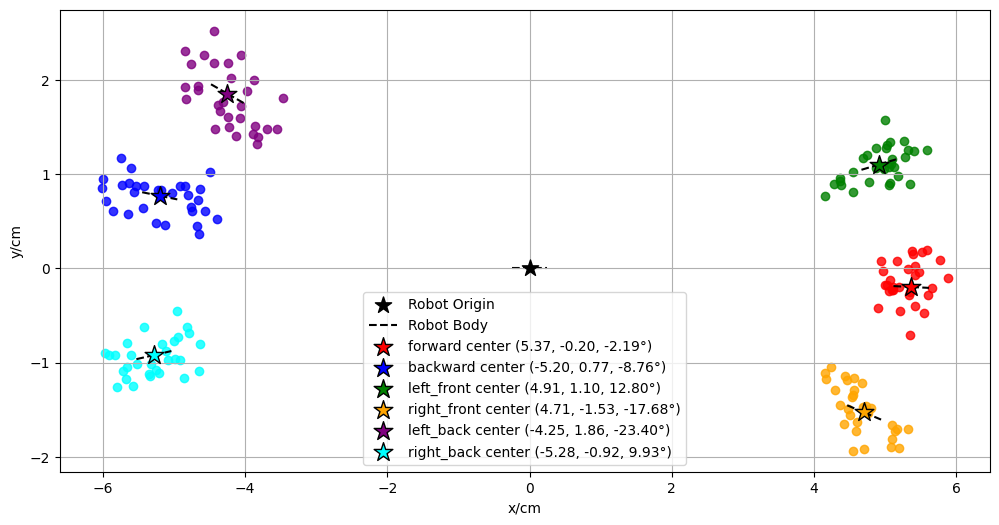

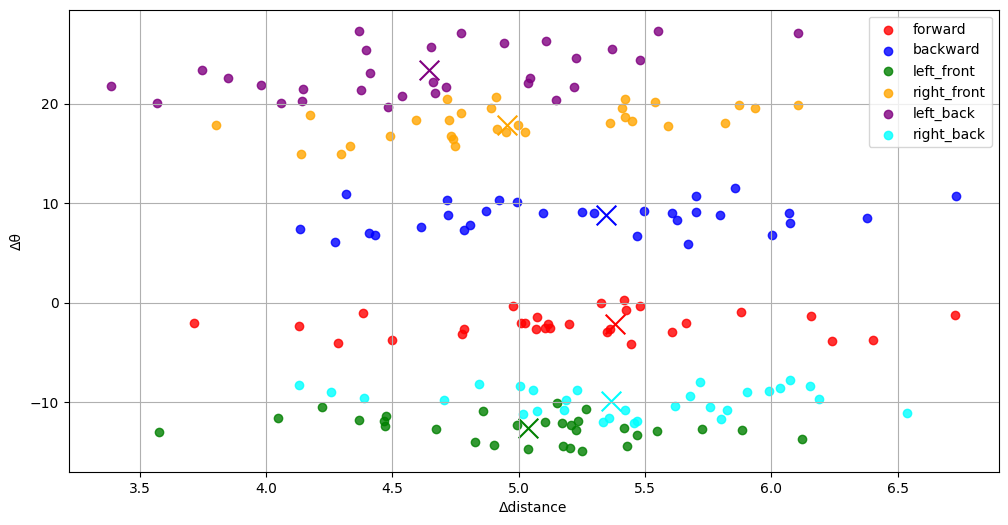

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_gait_data(gait_name):
    """Load gait data from the corresponding JSON file."""
    filename = f"{gait_name}_data.json"
    data = []
    try:
        with open(filename, "r") as file:
            for line in file:
                data.append(json.loads(line))
    except FileNotFoundError:
        print(f"File {filename} not found.")
    return data

def normalize_angle(angle):
    """Normalize an angle to the range [-180, 180]."""
    return ((angle + 180) % 360) - 180

def rotate_and_translate(delta_distance, delta_theta, gait_name):
    """
    Convert Δdistance and Δtheta to Δx, Δy in the global frame,
    adjusted for gait-specific motion directions.
    """
    # Update heading (in radians)
    new_theta = np.radians(delta_theta)

    # Compute global Δx and Δy
    delta_x = delta_distance * np.cos(new_theta)
    delta_y = delta_distance * np.sin(new_theta)

    if gait_name == "forward":
        return delta_x, delta_y
    elif gait_name == "backward":
        return -delta_x, delta_y
    elif gait_name == "left_front":
        return delta_x, -delta_y
    elif gait_name == "right_front":
        return delta_x, -delta_y
    elif gait_name == "left_back":
        return -delta_x, delta_y
    elif gait_name == "right_back":
        return -delta_x, delta_y
    else:
        raise ValueError(f"Unknown gait name: {gait_name}")

def remove_outliers(data):
    """Remove outliers using the IQR method."""
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only points within the bounds
    return data[
        (data[:, 0] >= lower_bound[0]) & (data[:, 0] <= upper_bound[0]) &
        (data[:, 1] >= lower_bound[1]) & (data[:, 1] <= upper_bound[1])
    ]

def filter_closest_points(data, center, n):
    """Filter the n closest points to the cluster center."""
    distances = np.sqrt((data[:, 0] - center[0])**2 + (data[:, 1] - center[1])**2)
    closest_indices = np.argsort(distances)[:n]
    return data[closest_indices]

def plot_comparison(clean_data_dict, n_closest=None, robot_width=0.5):
    """Plot comparison of x, y positions for all gaits."""
    colors = ["red", "blue", "green", "orange", "purple", "cyan"]
    gaits = list(clean_data_dict.keys())
    legend_handles = []  # To customize the legend

    plt.figure(figsize=(12, 6))

    # Draw the original robot position
    origin_handle = plt.scatter(0, 0, color="black", marker="*", s=150, label="Robot Origin", zorder=3)
    robot_body_handle, = plt.plot(
        [-robot_width / 2, robot_width / 2],
        [0, 0],
        color="black",
        linestyle="--",
        zorder=1,  # Lower z-order for the robot body line
        label="Robot Body"
    )
    legend_handles.append(origin_handle)
    legend_handles.append(robot_body_handle)

    for i, gait in enumerate(gaits):
        clean_data = clean_data_dict[gait]
        delta_x2 = np.array([entry["delta_x2"] for entry in clean_data])
        delta_y2 = np.array([entry["delta_y2"] for entry in clean_data])
        delta_theta = np.array([entry["delta_theta"] for entry in clean_data])

        data = np.column_stack((delta_x2, delta_y2))

        # Remove outliers
        filtered_data = remove_outliers(data)

        # Calculate cluster center without outliers
        center_x = np.mean(filtered_data[:, 0])
        center_y = np.mean(filtered_data[:, 1])
        center_theta = np.mean(delta_theta)  # Average orientation

        if gait == "forward":
            center_theta = center_theta
        else:
            center_theta = -center_theta  # Invert angle for other gaits

        center = np.array([center_x, center_y])

        # Filter closest n points if specified
        if n_closest is not None:
            filtered_data = filter_closest_points(filtered_data, center, n_closest)
            delta_x2, delta_y2 = filtered_data[:, 0], filtered_data[:, 1]
        else:
            delta_x2, delta_y2 = filtered_data[:, 0], filtered_data[:, 1]

        # Scatter plot for x, y positions as dots
        data_handle = plt.scatter(
            delta_x2, delta_y2, color=colors[i], label=f"{gait}", alpha=0.8, marker="o", zorder=1
        )

        # Represent center with a star (*) with black edge
        center_handle = plt.scatter(
            center[0], center[1], color=colors[i], marker="*", s=200, edgecolor="black", zorder=3
        )

        # Draw dashed lines for robot body style at center in black
        line_length = 0.5  # Total length of the dashed line segments
        front_x = center_x + (line_length / 2) * np.cos(np.radians(center_theta))
        front_y = center_y + (line_length / 2) * np.sin(np.radians(center_theta))
        back_x = center_x - (line_length / 2) * np.cos(np.radians(center_theta))
        back_y = center_y - (line_length / 2) * np.sin(np.radians(center_theta))
        plt.plot(
            [back_x, center_x],
            [back_y, center_y],
            color="black",
            linestyle="--",
            linewidth=1.5,
            zorder=2  # Lower z-order for the line
        )
        plt.plot(
            [center_x, front_x],
            [center_y, front_y],
            color="black",
            linestyle="--",
            linewidth=1.5,
            zorder=2  # Lower z-order for the line
        )

        # Add the center label to the legend
        legend_handles.append(center_handle)
        legend_handles[-1].set_label(
            f"{gait} center ({center_x:.2f}, {center_y:.2f}, {center_theta:.2f}°)"
        )

    plt.xlabel("x/cm")
    plt.ylabel("y/cm")
    plt.legend(handles=legend_handles, loc="best")
    plt.grid(True)
    plt.savefig("plot_comparison.png", dpi=300, bbox_inches="tight")
    # plt.show()




def plot_distance_vs_theta(clean_data_dict, n_closest=None):
    """Plot comparison of Δdistance vs Δtheta for all gaits."""
    colors = ["red", "blue", "green", "orange", "purple", "cyan"]
    gaits = list(clean_data_dict.keys())

    plt.figure(figsize=(12, 6))

    for i, gait in enumerate(gaits):
        clean_data = clean_data_dict[gait]
        delta_distance = np.array([entry["delta_distance"] for entry in clean_data])
        delta_theta = np.array([entry["delta_theta"] for entry in clean_data])

        data = np.column_stack((delta_distance, delta_theta))

        # Remove outliers
        filtered_data = remove_outliers(data)

        # Calculate cluster center without outliers
        center_x = np.mean(filtered_data[:, 0])
        center_y = np.mean(filtered_data[:, 1])
        center = np.array([center_x, center_y])

        # Filter closest n points if specified
        if n_closest is not None:
            filtered_data = filter_closest_points(filtered_data, center, n_closest)
            delta_distance, delta_theta = filtered_data[:, 0], filtered_data[:, 1]
        else:
            delta_distance, delta_theta = filtered_data[:, 0], filtered_data[:, 1]

        # Scatter plot for Δdistance vs Δtheta as dots
        plt.scatter(delta_distance, delta_theta, color=colors[i], label=f"{gait}", alpha=0.8, marker="o")

        # Represent center with a large 'x'
        plt.scatter(center[0], center[1], color=colors[i], marker="x", s=200, edgecolor="black")

    plt.xlabel("Δdistance")
    plt.ylabel("Δθ")
    # plt.xlim(0, 10) 
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    gaits = ["forward", "backward", "left_front", "right_front", "left_back", "right_back"]
    clean_data_dict = {}

    for gait in gaits:
        raw_data = load_gait_data(gait)

        delta_data = []
        for entry in raw_data:
            # Raw data deltas
            delta_x1 = entry["goal_x"] - entry["start_x"]
            delta_y1 = entry["goal_y"] - entry["start_y"]
            delta_distance = np.sqrt(delta_x1**2 + delta_y1**2)
            delta_theta = normalize_angle(entry["goal_theta"] - entry["start_theta"])

            # Calculated deltas
            delta_x2, delta_y2 = rotate_and_translate(
                delta_distance, delta_theta, gait
            )

            delta_data.append({
                "delta_x1": delta_x1,
                "delta_y1": delta_y1,
                "delta_x2": delta_x2,
                "delta_y2": delta_y2,
                "delta_distance": delta_distance,
                "delta_theta": delta_theta,
            })

        clean_data_dict[gait] = delta_data

    # Number of closest points to use (None = use all points)
    n_closest_points = 30

    # Plot Δx_2 vs Δy_2
    plot_comparison(clean_data_dict, n_closest=n_closest_points)



    # Plot Δdistance vs Δθ
    plot_distance_vs_theta(clean_data_dict, n_closest=n_closest_points)


In [498]:
# Load the gait averages
with open("gait_averages.json", "r") as file:
    gait_averages = json.load(file)

# Example: Query the average effect of "forward" gait
forward_avg = gait_averages["forward"]
print(f"Forward Gait Average: {forward_avg}")


Forward Gait Average: {'avg_delta_x': -0.5193933003866164, 'avg_delta_y': -1.1193640121240755, 'avg_delta_distance': 5.096174564425657, 'avg_delta_theta': -1.8139396977608926}


In [433]:
print(gait_averages)

{'forward': {'avg_delta_x': -9.855956879050973, 'avg_delta_y': 2.1149952458279815, 'avg_delta_distance': 10.22982780229047, 'avg_delta_theta': 20.730895579210987}, 'backward': {'avg_delta_x': 4.190961349024684, 'avg_delta_y': 1.9107116712866543, 'avg_delta_distance': 5.369284883403863, 'avg_delta_theta': 10.195269588585793}, 'left_front': {'avg_delta_x': 1.0722943949466526, 'avg_delta_y': 1.2035366477537734, 'avg_delta_distance': 1.9690449685231097, 'avg_delta_theta': -15.042019153691786}, 'right_front': {'avg_delta_x': -0.08195966645859584, 'avg_delta_y': -4.752370353629052, 'avg_delta_distance': 5.4519510154427255, 'avg_delta_theta': 27.65190834183457}, 'left_back': {'avg_delta_x': 0.06258897370165642, 'avg_delta_y': 2.008979489820388, 'avg_delta_distance': 2.038706122480062, 'avg_delta_theta': -6.816995912701351}, 'right_back': {'avg_delta_x': 2.8417598684623044, 'avg_delta_y': -2.5066570124656833, 'avg_delta_distance': 4.085124009957847, 'avg_delta_theta': 9.124680804446436}}


# planning the motion

In [383]:
if __name__ == "__main__":
    tag0_status = query_robot_status(0)
    tag1_status = query_robot_status(1)

    if tag0_status:
        print(f"Tag 0 Position: x={tag0_status['x']:.2f}, y={tag0_status['y']:.2f}, theta={tag0_status['theta']:.2f}°")
    else:
        print("Tag 0 position is inconsistent or not available.")

    if tag1_status:
        print(f"Tag 1 Position: x={tag1_status['x']:.2f}, y={tag1_status['y']:.2f}, theta={tag1_status['theta']:.2f}°")
    else:
        print("Tag 1 position is inconsistent or not available.")


Tag 0 Position: x=62.06, y=-100.22, theta=59.16°
Tag 1 Position: x=353.43, y=8.78, theta=29.67°


In [202]:
import numpy as np
import time
import json
from multiprocessing.managers import BaseManager

# Load precomputed gait averages (replace with your actual file path)
with open("gait_averages.json", "r") as file:
    gait_averages = json.load(file)

# Define weights and thresholds
distance_weight = 1.0  # Weight for distance difference
angle_weight = 0     # Weight for angle difference
distance_threshold = 5.0  # cm
angle_threshold = 20.0     # degrees

def calculate_goal_with_tag(target_position, connection_type="head_to_head"):
    """
    Calculate the goal position for Robot 0 based on Robot 1's Tag position, orientation, and connection type.
    """
    # Robot dimensions
    robot_length = 20  # cm (longer side)
    robot_width = 10   # cm (shorter side)

    target_x = target_position["x"]
    target_y = target_position["y"]
    target_theta = target_position["theta"]  # In degrees
    target_theta_rad = np.radians(target_theta)

    if connection_type == "head_to_head":
        goal_x = target_x - robot_length * np.cos(target_theta_rad)
        goal_y = target_y - robot_length * np.sin(target_theta_rad)
        goal_theta = (target_theta + 180) % 360

    elif connection_type == "head_to_tail":
        goal_x = target_x + robot_length * np.cos(target_theta_rad)
        goal_y = target_y + robot_length * np.sin(target_theta_rad)
        goal_theta = target_theta

    elif connection_type == "head_to_side":
        goal_x = target_x + robot_width * np.sin(target_theta_rad)
        goal_y = target_y - robot_width * np.cos(target_theta_rad)
        goal_theta = (target_theta + 90) % 360

    elif connection_type == "tail_to_side":
        goal_x = target_x + robot_width * np.sin(target_theta_rad)
        goal_y = target_y - robot_width * np.cos(target_theta_rad)
        goal_theta = (target_theta - 90) % 360

    else:
        raise ValueError(f"Invalid connection type: {connection_type}")

    return {"x": goal_x, "y": goal_y, "theta": goal_theta}

def calculate_cost(current, target, gait_effect):
    """
    Calculate the cost of a gait based on distance and angle differences.
    """
    predicted_x = current["x"] + gait_effect["avg_delta_x"]
    predicted_y = current["y"] + gait_effect["avg_delta_y"]
    predicted_theta = current["theta"] + gait_effect["avg_delta_theta"]

    distance = np.sqrt((predicted_x - target["x"])**2 + (predicted_y - target["y"])**2)
    if distance >= 150:
        distance_weight = 1.0  # Weight for distance difference
        angle_weight = 0     # Weight for angle difference
    elif distance < 150 and distance >= 100:
        distance_weight = 1.0  # Weight for distance difference
        angle_weight = 0.1     # Weight for angle difference
    else:
        distance_weight = 1.0  # Weight for distance difference
        angle_weight = 0.5     # Weight for angle difference
        
    angle_diff = abs(predicted_theta - target["theta"]) % 360
    if angle_diff > 180:
        angle_diff = 360 - angle_diff

    cost = distance_weight * distance + angle_weight * angle_diff
    return cost

def move_robot_to_goal(rid, tag_id_0, tag_id_1, connection_type="head_to_side"):
    """
    Plan and execute movements to move Robot 0 to the goal position relative to Robot 1.
    """
    try:
        while True:
            current_position = query_robot_status(tag_id_0)
            target_position = query_robot_status(tag_id_1)

            if not current_position or not target_position:
                print("Failed to query positions. Retrying...")
                time.sleep(1)
                continue

            goal_position = calculate_goal_with_tag(target_position, connection_type)
            print(f"Goal Position: {goal_position}")

            distance = np.sqrt(
                (current_position["x"] - goal_position["x"])**2 +
                (current_position["y"] - goal_position["y"])**2
            )
            angle_diff = abs(current_position["theta"] - goal_position["theta"]) % 360
            if angle_diff > 180:
                angle_diff = 360 - angle_diff

            print(f"Distance to Goal: {distance:.2f} cm, Angle Difference: {angle_diff:.2f}°")
            if distance <= distance_threshold and angle_diff <= angle_threshold:
                print("Goal reached!")
                break

            best_gait = None
            lowest_cost = float("inf")
            for gait_name, gait_effect in gait_averages.items():
                cost = calculate_cost(current_position, goal_position, gait_effect)
                # print("the current cost is: ", cost, "gait_name: ", gait_name)
                if cost < lowest_cost:
                    lowest_cost = cost
                    best_gait = gait_name

            if best_gait:
                print(f"Executing Gait: {best_gait}")
                gait_functions[best_gait](rid)
            else:
                print("No valid gait found. Stopping.")
                break

            time.sleep(1)

    except KeyboardInterrupt:
        print("Program interrupted manually.")

gait_functions = {
    "forward": move_forward,
    "backward": move_backward,
    "left_front": move_left_front,
    "right_front": move_right_front,
    "left_back": move_left_back,
    "right_back": move_right_back,
}


In [ ]:
if __name__ == "__main__":
    rid = 15  # Robot 0 ID
    tag_id_0 = 0  # Tag ID for Robot 0
    tag_id_1 = 1  # Tag ID for Robot 1

    move_robot_to_goal(rid, tag_id_0, tag_id_1, connection_type="head_to_tail")


In [435]:
rid = 15

set_robot(robotwithID[rid], 00, 255, 0, 255, False, 0)

{'status': 'set ok',
 'ip': '192.168.8.207',
 'mac': 'D8:3B:DA:C3:87:8E',
 'm1_current': 2,
 'm1_target': 0,
 'm2_current': -25,
 'm2_target': 0,
 'm1_power': 255,
 'm2_power': 255,
 'm3_power': 0,
 'm1_error': 0,
 'm2_error': 0,
 'battery': 1.14,
 'pause': False}

In [ ]:
# if __name__ == "__main__":
#     # Sequentially connect robots by calling `move_robot_to_goal`
#     print("\nConnecting Robot 0 to Robot 1 (head-to-head)...")
#     move_robot_to_goal(rid=0, tag_id_0=0, tag_id_1=1, connection_type="head_to_head")
#     print("Robot 0 successfully connected to Robot 1.\n")

#     print("Connecting Robot 2 to Robot 1 (head-to-side)...")
#     move_robot_to_goal(rid=2, tag_id_0=2, tag_id_1=1, connection_type="head_to_side")
#     print("Robot 2 successfully connected to Robot 1.\n")

#     print("Connecting Robot 3 to Robot 0 (head-to-side)...")
#     move_robot_to_goal(rid=3, tag_id_0=3, tag_id_1=0, connection_type="head_to_side")
#     print("Robot 3 successfully connected to Robot 0.\n")
